# Anomaly detection in time series

This was taken from [Pramit Choudhary's DataScience.com blog post](https://www.datascience.com/blog/python-anomaly-detection) on anomaly detection in time series. The series used was the number of sunspots vs time. There is a natural fluctuation to the cycle.

I have made some small changes, namely:
1. Added the &sigma;-value error bars
2. Replaced the deprecated Pandas functions `pd.rolling_std( dataframe, window_size )` to `DataFrame.rolling(window_size).std()`
3. Replaced custom moving average function with `DataFrame.rolling(window_size).mean()` for consistency
4. Other minor changes to tidy up the code.

Below I try using an RNN approach to the same dataset.

In [1]:
from itertools import izip, count

import numpy as np
import pandas as pd
import collections

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
# Read in the data
sunspot_data = pd.read_csv("sunspots.txt",delimiter = '\t', header= None, names = ['month','sunspots'])
sunspot_data.head()

,month,sunspots
0,0,58.0
1,1,62.6
2,2,70.0
3,3,55.7
4,4,85.0


In [3]:
def explain_anomalies(y, window_size, sigma = 1.0):
    rolling = y.rolling(window_size)
    average = rolling.mean().replace(np.nan, y)
    residual = y - average
    std = np.std(residual)
    return {'standard_deviation': std,
            'anomalies_dict': collections.OrderedDict(
            [(index,y_i) for index, y_i, avg_i in izip(count(), y, average)
            if abs(y_i - avg_i) > sigma * std]
        )}

def explain_anomalies_rolling_std(y, window_size, sigma = 1.0):
    rolling = y.rolling(window_size)
    average = rolling.mean().replace(np.nan, y)
    residual = y - average
    
    testing_std = residual.rolling(window_size).std()
    return {'standard_deviation': testing_std,
            'anomalies_dict': collections.OrderedDict(
            [(index, y_i) for index, y_i, avg_i, rs_i in izip(count(), y, average, testing_std)
            if abs(y_i - avg_i) > sigma*rs_i])}

In [4]:
def plot_results(x, y, window_size, num_sigma = 1.0, text_xlabel = "X Axis", 
                text_ylabel = "Y Axis", apply_rolling_std=False):
    plt.figure(figsize = (15,8))
    plt.plot(x,y,'k.')
    y_av = y.rolling(window_size).mean()
    plt.plot(x,y_av, color='green')
    plt.xlim(x.min(),x.max())
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    if apply_rolling_std:
        anomaly_function = explain_anomalies_rolling_std
    else:
        anomaly_function = explain_anomalies
        
    events = anomaly_function(y, window_size = window_size, sigma=num_sigma)
    
    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype = int, count = len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(),dtype=float,count = len(events['anomalies_dict']))
    y_lower = y_av - num_sigma * events['standard_deviation']
    y_upper = y_av + num_sigma * events['standard_deviation']
    
    plt.plot(x_anomaly, y_anomaly,'r*', markersize = 12)
    plt.fill_between(x, y_upper, y_lower,alpha = 0.3)
    plt.grid(True)
    

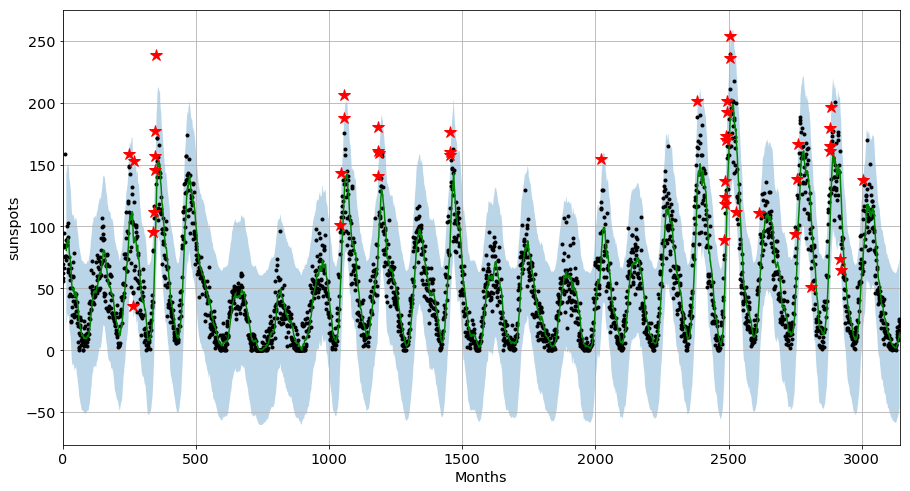

In [5]:
plot_results(sunspot_data['month'], sunspot_data['sunspots'], window_size = 15, text_xlabel = "Months", 
             text_ylabel="sunspots", num_sigma = 3, apply_rolling_std = False)

## RNN

This is also a time-series, so we can try training an RNN to predict future values. We are using the default values found in "Hands-on machine learning with Scikit-Learn & TensorFlow" by A. Geron

This is a single-layer RNN, where that single layer has 100 neurons.

In [6]:
import tensorflow as tf

n_steps = 150
n_inputs = 1
n_neurons = 250
n_outputs = 1

# only use the first 2000 months for training data
n_train = 2000

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation = tf.nn.relu), output_size = n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [7]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

# 

In [8]:
def next_batch(batch_size, n_steps, n_train = n_train):
    # pick one of the first 2000 starting points
    start = (np.random.rand(batch_size)*n_train).astype(np.int)
    X_batch = [sunspot_data['sunspots'][initial: initial + n_steps].values for initial in start]
    y_batch = [sunspot_data['sunspots'][initial + 1: initial + n_steps + 1] for initial in start]
    
    return np.array(X_batch).reshape(-1, n_steps, 1), np.array(y_batch).reshape(-1, n_steps, 1)

In [9]:
n_iterations = 8001
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict = {X: X_batch, y: y_batch})
        if iteration% 200 == 0:
            mse = loss.eval(feed_dict = {X: X_batch, y: y_batch})
            print "{:3d}  MSE = {:8.6f}".format(iteration, mse)
    
    # Save the session for later
    saver.save(sess, "./my_time_series_model")

  0  MSE = 2383.769775
200  MSE = 191.982559
400  MSE = 125.762917
600  MSE = 68.128059
800  MSE = 43.510265
1000  MSE = 28.273811
1200  MSE = 31.248711
1400  MSE = 21.629717
1600  MSE = 20.486046
1800  MSE = 24.368046
2000  MSE = 19.278711
2200  MSE = 28.584204
2400  MSE = 23.776266
2600  MSE = 24.201870
2800  MSE = 16.197165
3000  MSE = 25.986542
3200  MSE = 14.897695
3400  MSE = 17.793140
3600  MSE = 21.644901
3800  MSE = 19.477283
4000  MSE = 16.627964
4200  MSE = 21.609571
4400  MSE = 12.783605
4600  MSE = 18.852821
4800  MSE = 14.407549
5000  MSE = 18.815756
5200  MSE = 13.944361
5400  MSE = 13.691846
5600  MSE = 17.302397
5800  MSE = 17.103394
6000  MSE = 14.905979
6200  MSE = 12.993241
6400  MSE = 10.655456
6600  MSE = 13.661227
6800  MSE = 13.067302
7000  MSE = 16.868448
7200  MSE = 14.353539
7400  MSE = 11.402961
7600  MSE = 12.520400
7800  MSE = 14.639587
8000  MSE = 80.466484


In [10]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    sequence = []
    for iteration in range(2800):
        X_batch = np.array(sunspot_data['sunspots'][iteration: iteration + n_steps]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict = {X: X_batch})
        sequence.append((iteration + n_steps + 1, y_pred[0,-1,0]) )
        

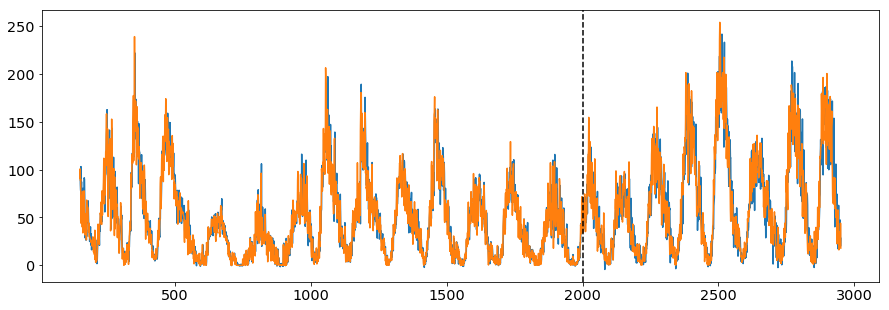

In [11]:
Xa = [s[0] for s in sequence]
Yp = [s[1] for s in sequence]
Ya = sunspot_data['sunspots'][n_steps + 1 : n_steps + 1 + len(Xa)]
plt.plot(Xa,Yp,Ya)
plt.axvline(x=n_train, color='k', linestyle='--')

In [12]:
residual = np.array(Yp) - np.array(Ya)

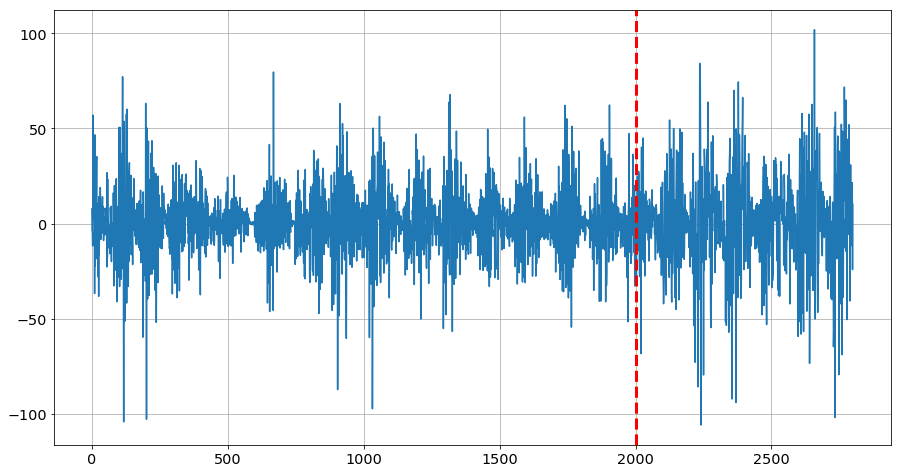

In [13]:
plt.figure(figsize = (15,8))
plt.grid(True)
plt.plot(residual)
plt.axvline(x=n_train, color='r', linewidth = 3, linestyle='--');

In [14]:
np.std(residual)

20.050551775567911

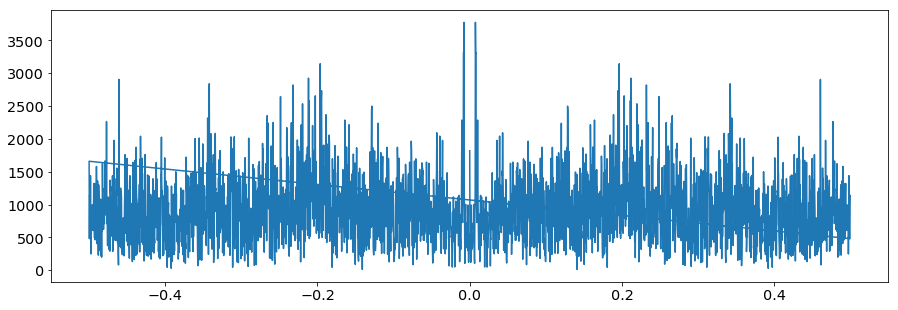

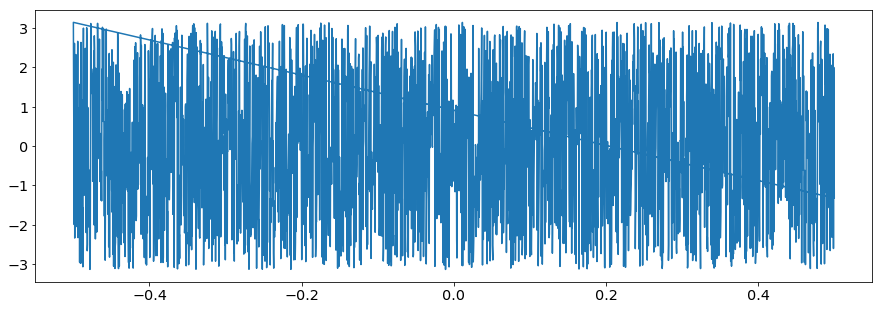

In [15]:
resFFT    = np.fft.fft(residual)
freq = np.fft.fftfreq(len(residual), 1)

plt.figure()
plt.plot( freq, np.abs(resFFT) )
plt.figure()
plt.plot(freq, np.angle(resFFT) )
plt.show()

In [16]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    gen_sequence = sunspot_data['sunspots'][:n_train].values.tolist()
    for iteration in range(2000):
        X_batch = np.array(gen_sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict = {X: X_batch})
        gen_sequence.append(y_pred[0,-1,0] )

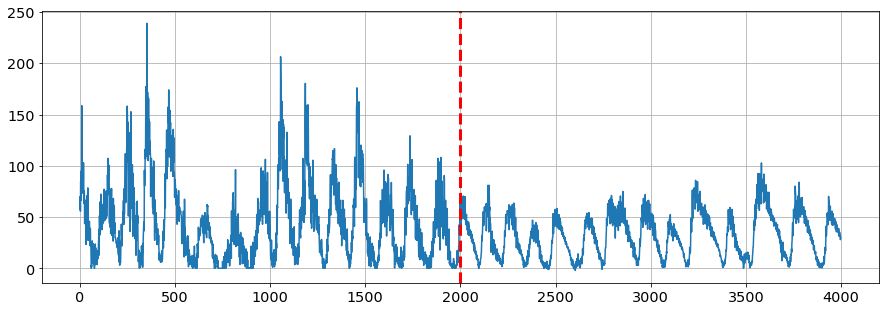

In [17]:
plt.plot(gen_sequence)
plt.grid(True)
plt.axvline(x=n_train, color='r', linewidth = 3, linestyle='--');

# LTSM

To be completed.....